# Analyzing the UncertaintyForest Class by Reproducing Figure 2
This tutorial (`uncertaintyforest_fig2.ipynb`) will further explain the UncertaintyForest class by allowing you to generate Figure 2 from [this paper](https://arxiv.org/pdf/1907.00325.pdf) on your own machine. 

If you haven't seen it already, take a look at other tutorials to setup and install the progressive learning package `Installation-and-Package-Setup-Tutorial.ipynb`

*Goal: Run the UncertaintyForest class to produce the results from Figure 2*
*Note: Figure 2 refers to Figure 2 from [this paper](https://arxiv.org/pdf/1907.00325.pdf)*

## Import Required Packages

In [1]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from proglearn.forest import UncertaintyForest
from functions.unc_forest_tutorials_functions import generate_data_fig2, cart_estimate, true_cond_entropy, format_func, estimate_ce, get_cond_entropy_vs_n, get_cond_entropy_vs_mu, plot_cond_entropy_by_n, plot_cond_entropy_by_mu, plot_fig2

Using TensorFlow backend.


## Specify Parameters

In [2]:
# The following are two sets of parameters.
# The first are those that were actually used to produce figure 2.
# These take a long time to actually run since there are up to 6000 data points.
# Below those, you'll find some testing parameters so that you can see the results more quickly.

# Here are the "Real Parameters"
# mus = [i * 0.5 for i in range(1, 11)] 
# effect_size = 1
# d1 = 1 
# d2 = 20 
# n1 = 3000 
# n2 = 6000 
# num_trials = 20 
# num_plotted_trials = 10 
# sample_sizes_d1 = range(300, 1201, 90) 
# sample_sizes_d2 = range(500, 3001, 250)

# Here are the "Test Parameters"
mus = [i * 0.5 for i in range(1, 3)] # range of means of the data (x-axis in right column)
effect_size = 1 # mu for left column
d1 = 1 # data dimensions = 1
d2 = 3 # data dimensions = 1, noise dimensions = 19
n1 = 100 # number of data points for top row, right column (d1)
n2 = 110 # number of data points for bottom row, right column (d2)
num_trials = 2 # number of trials to run
num_plotted_trials = 2 # the number of "fainter" lines to be displayed on the figure
sample_sizes_d1 = range(100, 120, 10) # range of data points for top row, left column (d1)
sample_sizes_d2 = range(100, 130, 10) # range of data points for bottom row, left column (d1)


## Specify Learners
#### Now, we'll specify which learners we'll compare (by label). Figure 2 uses three different learners, which are further specified in the function estimate_ce, which returns estimates of conditional entropy for a given dataset (X, y) and type of learner.

In [3]:
# Algorithms used to produce figure 2
algos = [
    {
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

## Calculate conditional entropy
### Now, we'll run the code to obtain the results that will be displayed in Figure 2 (4 sets of calculations for 4 subplots)

In [4]:
# This is the code that actually generates data and predictions for conditional entropy vs. n or mu.
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.11214778, 0.11048867],
        [0.22178799, 0.14583895]],

       [[0.38342978, 0.4103195 ],
        [0.40773816, 0.42239194]],

       [[0.32206136, 0.40461966],
        [0.50872935, 0.42315098]]])

In [5]:
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[0.32994565, 0.36822724],
        [0.110139  , 0.1561771 ]],

       [[0.63830961, 0.58093   ],
        [0.36165212, 0.34929689]],

       [[0.5877224 , 0.63324166],
        [0.40249302, 0.44092106]]])

In [6]:
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.13126886, 0.19777364],
        [0.17694331, 0.15700058],
        [0.19413758, 0.20764642]],

       [[0.24105501, 0.33821574],
        [0.37824966, 0.27023768],
        [0.35340802, 0.3389403 ]],

       [[0.26258281, 0.46782391],
        [0.47191336, 0.35824319],
        [0.38142705, 0.51570431]]])

In [7]:
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[0.35830125, 0.36342964],
        [0.18200314, 0.16197208]],

       [[0.54444178, 0.56992694],
        [0.32021966, 0.23078676]],

       [[0.55594094, 0.63726618],
        [0.42760198, 0.38979981]]])

## Plot Figure 2

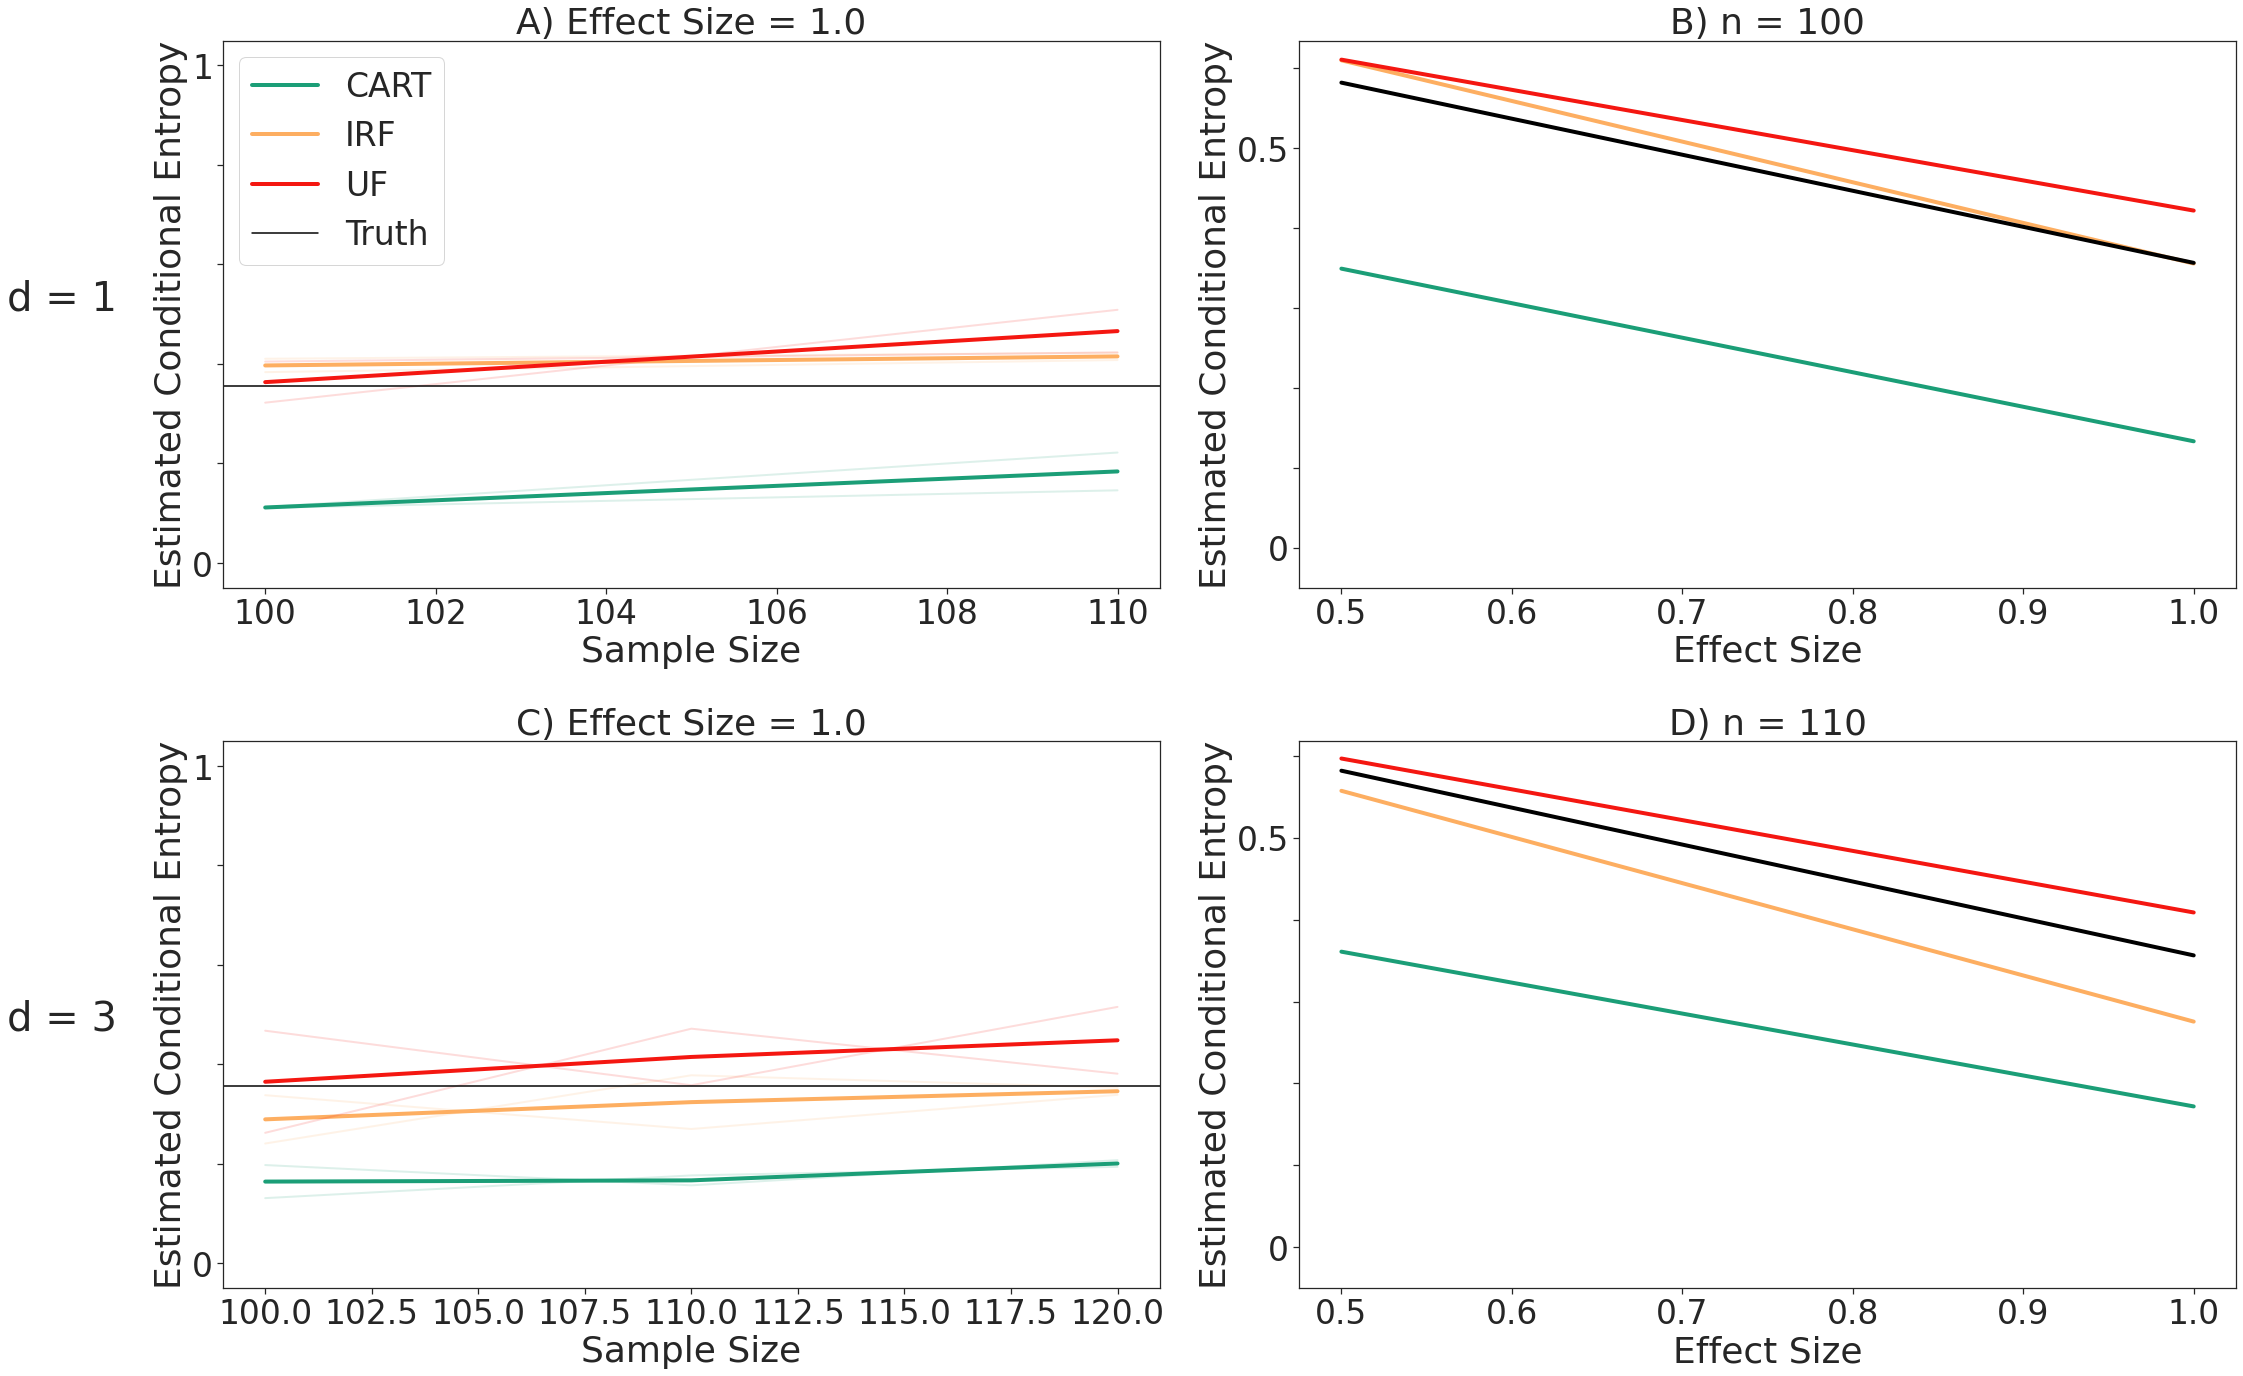

In [8]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)